#Modelo 3: BERT

##Librerias

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.4 MB/s eta 0:00:00


In [ ]:
!pip install -q tf-models-official==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import pandas as pd

tf.get_logger().setLevel('ERROR')

##Datos

In [ ]:
#lectura de datos sin procesar. se procesará con herramientas de Tensorflow
# df = pd.read_csv("/content/drive/MyDrive/Proyecto-Tesis/Data/data-100000.csv")
df = pd.read_csv("/content/drive/MyDrive/Proyecto/data-100000.csv")


In [ ]:
df['reviewText'] = df['reviewText'].astype('string')

In [ ]:
# sparamos los rating con 0 menores iguales a 3 y con 1 mayores a 3
df['overall'].value_counts()

5.0    66824
4.0    17461
3.0     6888
1.0     5301
2.0     3505
Name: overall, dtype: int64

In [ ]:
df.loc[df['overall'] < 3, 'overall'] = 0
df.loc[df['overall'] == 3, 'overall'] = 1
df.loc[df['overall'] > 3, 'overall'] = 2

In [ ]:
df['overall'].value_counts()

2.0    84285
0.0     8806
1.0     6888
Name: overall, dtype: int64

In [ ]:
# Separamos la data en train y test y Val
# num_classes = 3
# X, y = df.drop("overall", axis=1), df[['overall']]
X = df[['reviewText']]
y = df[['overall']]
# labels = to_categorical(y,num_classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2 ,random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5 ,random_state=1, stratify=y_val)

In [ ]:
# # Tranasformamos los datos para que sean leidos por funciones tensoflow
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=3)
# y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=3)
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=3)

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
# val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded))
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))

# # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# # val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# # test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:

# Codificación de las etiquetas como vectores one-hot
train_labels_one_hot = tf.one_hot(y_train, depth=3)
val_labels_one_hot = tf.one_hot(y_val, depth=3)
test_labels_one_hot = tf.one_hot(y_test, depth=3)

# Creación de los conjuntos de datos
train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_labels_one_hot))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, val_labels_one_hot))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, test_labels_one_hot))


In [ ]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(1, 3), dtype=tf.float32, name=None))>

In [ ]:
for row in train_ds.take(3):
  print(row)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"I loved my sony headphones.  These are a little more rigid and almost press to hard on my ears, but they stay on better when I'm working around the house, so they good in the respect.  They have good sound for what I use them for which is listening to audiobooks."],
      dtype=object)>, <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 1., 0.]], dtype=float32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"It works as indicated, but the quality of the hardware leaves a lot to be desired.  The bolts and screws are not made of a good grade steel and strip easily.  Also there's only one screw that controls the tilt of the tv, and because it's hard to reach and hard to use since it strips so easily, you're kind of left with a cock-eyed installation."],
      dtype=object)>, <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 1., 0.]], dtype=float32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Thi

#Modelo BERT


In [ ]:
# El modelo fue desarrollado en base a la documentacion proporcionada por TensorFlow

# Definimos el modelo de BERT que se va a usar, En este caso se trabajará con el modelo small_bert
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
#Definimos una función para la creación del modelo
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)  
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# el clasificador retorna una probabilidad.
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6208768  0.5317992  0.59371865]], shape=(1, 3), dtype=float32)


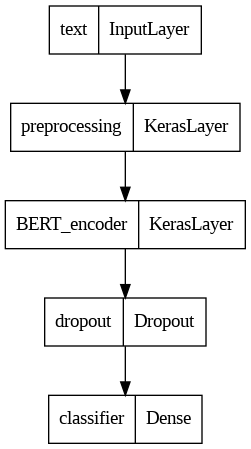

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#Se defini el Loss funtion
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
# Se define un optimizador, es este caso se usa el mismo optimizador que usar BERT, Adam.
# igualmente con el learning reate (init_lr = 5e-5)
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# agregamos los parametros
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
#Entrenamos el modelo
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, 
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
79983/79983 [==============================] - 2725s 34ms/step - loss: 0.6997 - categorical_accuracy: 0.8695 - val_loss: 0.5597 - val_categorical_accuracy: 0.8865
Epoch 2/5
79983/79983 [==============================] - 2728s 34ms/step - loss: 0.5704 - categorical_accuracy: 0.8931 - val_loss: 0.5632 - val_categorical_accuracy: 0.8883
Epoch 3/5
79983/79983 [==============================] - 2714s 34ms/step - loss: 0.4882 - categorical_accuracy: 0.9082 - val_loss: 0.6072 - val_categorical_accuracy: 0.8939
Epoch 4/5
79983/79983 [==============================] - 2728s 34ms/step - loss: 0.4177 - categorical_accuracy: 0.9251 - val_loss: 0.6748 - val_categorical_accuracy: 0.8933
Epoch 5/5
79983/79983 [==============================] - 2744s 34ms/step - loss: 0.3521 - categorical_accuracy: 0.9391 - val_loss: 0.7037 - val_categorical_accuracy: 0.8954


In [ ]:
#Testeamos el modelo
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9998/9998 [==============================] - 120s 12ms/step - loss: 0.7337 - categorical_accuracy: 0.8904
Loss: 0.7336640357971191
Accuracy: 0.8903780579566956


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


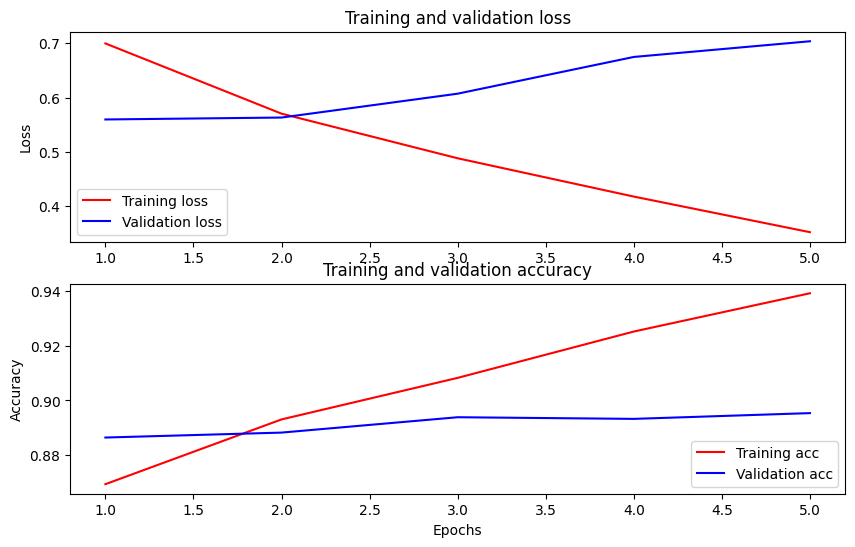

In [ ]:
#Grafico del entrenamiento del modelo
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Guardamos el Modelo


In [ ]:
dataset_name = 'amazonReview'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!', 
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.500001
input: The movie was great!           : score: 0.500001
input: The movie was meh.             : score: 0.500287
input: The movie was okish.           : score: 0.500239
input: The movie was terrible...      : score: 0.730948

Results from the model in memory:
input: this is such an amazing movie! : score: 0.500001
input: The movie was great!           : score: 0.500001
input: The movie was meh.             : score: 0.500287
input: The movie was okish.           : score: 0.500239
input: The movie was terrible...      : score: 0.730948

